### 导入相关的库

In [1]:
import os
import json
import torch
import torch.nn.functional as F
import random
import time
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier as SklearnMLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np

### 将模型转移到gpu

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 导入Unixcoder模型

In [3]:
# 加载tokenizer和模型
# 加载模型和tokenizer
tokenizer = AutoTokenizer.from_pretrained("../../model/unixcoder/")
model = AutoModel.from_pretrained("../../model/unixcoder/").to(device)

### 加载数据样本
基本格式如下：
```json
{
    "title": "JAVA-PY Sample",
    "code": "public class Example { ... }",
    "language": "java",
    "positive": {
        "language_positive": "py",
        "label": "1",
        "code_positive": [
            {"code": "def example(): ..."},
            {"code": "class Example: ..."}
        ]
    },
    "negative": {
        "language_negative": "py",
        "label": "0",
        "code_negative": [
            {"code": "def unrelated(): ..."},
            {"code": "class Unrelated: ..."}
        ]
    }
}
```

In [4]:
# 加载并处理样本数据
def load_samples_from_jsonl(file_path, max_samples=3):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            record = json.loads(line.strip())
            samples.append(record)
            if len(samples) >= max_samples:
                break
    return samples

samples = load_samples_from_jsonl('../../Datasets/code_pairs_java_python.jsonl')

### 对数据进行编码，先用Tokenizer进行分词，再用GraphCodeBert模型进行编码

In [5]:
# 对样本数据进行编码
def encode_sample(sample, tokenizer, model, device, max_length=512):
    code_inputs = tokenizer(sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                            max_length=max_length).to(device)
    with torch.no_grad():
        code_embedding = model(**code_inputs).last_hidden_state.mean(dim=1).cpu()

    positive_embeddings = []
    for positive_sample in sample['positive']['code_positive']:
        pos_inputs = tokenizer(positive_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            pos_embedding = model(**pos_inputs).last_hidden_state.mean(dim=1).cpu()
        positive_embeddings.append(pos_embedding)

    negative_embeddings = []
    for negative_sample in sample['negative']['code_negative']:
        neg_inputs = tokenizer(negative_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            neg_embedding = model(**neg_inputs).last_hidden_state.mean(dim=1).cpu()
        negative_embeddings.append(neg_embedding)

    return {
        'code_embedding': code_embedding,
        'positive_embeddings': positive_embeddings,
        'negative_embeddings': negative_embeddings
    }

encoded_samples = [encode_sample(sample, tokenizer, model, device) for sample in samples]

In [6]:
#### solotion3
class CombinedProjectionHead(nn.Module):
    def __init__(self, input_dim):
        super(CombinedProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.selective_fc = nn.Linear(input_dim, input_dim)
        self.swish = nn.SiLU()
        self.control_weight = nn.Parameter(torch.ones(input_dim))  # 学习的权重参数
        self.fc2 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        # 第一个全连接层
        x = self.fc1(x)
        
        # 选择性激活部分
        selective_output = self.swish(self.selective_fc(x)) * x
        
        # 使用控制权重进行调整
        adjusted_output = selective_output * self.control_weight
        
        # 第二个全连接层
        output = self.fc2(adjusted_output)
        return output


class SimCLR(nn.Module):
    def __init__(self, input_dim=768):
        super(SimCLR, self).__init__()
        self.projection_head = CombinedProjectionHead(input_dim)

    def forward(self, x):
        return self.projection_head(x)

contrastive_model = SimCLR(input_dim=768).to(device)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=3e-4)

In [7]:
# 定义新的对比学习损失函数
'''
参数:
anchor:锚点
positives:正样本集
negatives:负样本
temperatures:负样本集
'''
def simclr_contrastive_loss(anchor, positives, negatives, temperature=0.2):
    anchor = F.normalize(anchor, dim=1)
    positives = [F.normalize(pos, dim=1) for pos in positives]
    negatives = [F.normalize(neg, dim=1) for neg in negatives]

    positive_loss = 0
    for pos in positives:
        pos_similarity = torch.exp(torch.mm(anchor, pos.t()) / temperature)
        neg_similarity = sum(torch.exp(torch.mm(anchor, neg.t()) / temperature) for neg in negatives)
        positive_loss += -torch.log(pos_similarity / (pos_similarity + neg_similarity)).mean()

    loss = positive_loss / len(positives)
    return loss

In [8]:
# 定义数据集
class CodeCloneDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        anchor = sample['code_embedding'].view(1, -1)  # 确保 anchor 是二维矩阵
        positives = [pos.view(1, -1) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.view(1, -1) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵
        return anchor, positives, negatives

In [59]:
# 用于存储每个 epoch 的控制权重
control_weights_history = []
# 记录初始化时的控制权重
# initial_control_weights = contrastive_model.projection_head.control_weight.detach().cpu().numpy()
# control_weights_history.append(initial_control_weights)
def train_contrastive_model(encoded_samples, val_encoded_samples, contrastive_model, epochs=100, temperature=0.2):
    global control_weights_history
    train_dataset = CodeCloneDataset(encoded_samples)
    val_dataset = CodeCloneDataset(val_encoded_samples)

    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    contrastive_model.train()
    losses = []
    val_losses = []
    start_time = time.time()  # 记录训练开始时间

    for epoch in range(epochs):
        total_loss = 0
        contrastive_model.train()  # 设置模型为训练模式

        for i, (anchor, positives, negatives) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
            anchor = contrastive_model(anchor)
            positives = [contrastive_model(pos) for pos in positives]
            negatives = [contrastive_model(neg) for neg in negatives]
            anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
            positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
            negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
            loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        losses.append(avg_train_loss)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}', end=" ")

        # 记录当前 epoch 的控制权重
        current_control_weights = contrastive_model.projection_head.control_weight.detach().cpu().numpy()
        control_weights_history.append(current_control_weights)

        # 验证集评估
        contrastive_model.eval()  # 设置模型为评估模式
        total_val_loss = 0

        with torch.no_grad():
            for i, (anchor, positives, negatives) in enumerate(val_dataloader):
                anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]
                anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
                positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
                negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
                val_loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss}')

    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间
    return losses, val_losses, training_time

# # 调用 train_contrastive_model 训练模型
# contrastive_losses, val_losses, contrastive_training_time = train_contrastive_model(
#     train_samples, val_samples, contrastive_model, epochs=10, temperature=0.2
# )

In [60]:
# 训练对比学习模型
'''
参数

'''

def train_contrastive_model(encoded_samples, val_encoded_samples, contrastive_model, epochs=100, temperature=0.2):
    train_dataset = CodeCloneDataset(encoded_samples)
    val_dataset = CodeCloneDataset(val_encoded_samples)
    
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    contrastive_model.train()
    losses = []
    val_losses = []
    start_time = time.time()  # 记录训练开始时间
    
    for epoch in range(epochs):
        total_loss = 0
        contrastive_model.train()  # 设置模型为训练模式
        
        for i, (anchor, positives, negatives) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
            anchor = contrastive_model(anchor)
            positives = [contrastive_model(pos) for pos in positives]
            negatives = [contrastive_model(neg) for neg in negatives]
            anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
            positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
            negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
            loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_dataloader)
        losses.append(avg_train_loss)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}',end=" ")
        
        # 验证集评估
        contrastive_model.eval()  # 设置模型为评估模式
        total_val_loss = 0
        
        with torch.no_grad():
            for i, (anchor, positives, negatives) in enumerate(val_dataloader):
                anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]
                anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
                positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
                negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
                val_loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss}')
        # print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}')
        torch.cuda.empty_cache()
    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间
    return losses, val_losses, training_time


In [48]:
# 定义改进的MLP分类器
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 2)  # 二分类
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        combined = torch.cat((x1, x2), dim=1)
        out = self.fc1(combined)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.log_softmax(out)
        return out

In [49]:
# 训练和评估MLP分类器
def train_and_evaluate_model(model, criterion,optimizer,train_loader, val_loader, test_data, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_recalls = []
    val_f1s = []
    val_precisions = []
    
    start_time = time.time()  # 记录训练开始时间
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for (emb1, emb2), label in train_loader:
            emb1, emb2, label = emb1.to(device), emb2.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(emb1, emb2)
            loss = criterion(output, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        
        
        
        print(f'Epoch {epoch + 1}, Train Loss: {total_loss / len(train_loader):.4f}', end=" ")
        train_losses.append(total_loss / len(train_loader))
                
        # 验证集评估
        model.eval()
        total_val_loss = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for (emb1, emb2), label in val_loader:
                emb1, emb2, label = emb1.to(device), emb2.to(device), label.to(device)
                val_output = model(emb1, emb2)
                val_loss = criterion(val_output, label)
                total_val_loss += val_loss.item()
                val_preds = torch.argmax(val_output, dim=1)
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(label.cpu().numpy())
        
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_recall = recall_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds)
        val_precision = precision_score(all_val_labels, all_val_preds)
        
        print(  f'Val Loss: {total_val_loss / len(val_loader):.4f}')
     
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
    
    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间

    # 在测试集上评估
    model.eval()
    with torch.no_grad():
        emb1_test, emb2_test, labels_test = test_data
        start_time = time.time()  # 记录预测开始时间
        test_output = model(emb1_test, emb2_test)
        end_time = time.time()  # 记录预测结束时间
        prediction_time = end_time - start_time  # 计算预测时间
        test_preds = torch.argmax(test_output, dim=1).cpu().numpy()
        test_labels = labels_test.cpu().numpy()
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_recall = recall_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds)
        test_precision = precision_score(test_labels, test_preds)
        
        print(f'Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}, Test Precision: {test_precision:.4f}')
    
    return test_accuracy, test_recall, test_f1, test_precision, train_losses,val_losses, training_time, prediction_time



In [50]:
# 获取初始嵌入的评价指标
def evaluate_clones(samples, model, contrastive_model=None, mlp_model=None):
    model.eval()
    if contrastive_model:
        contrastive_model.eval()
    if mlp_model:
        mlp_model.eval()

    all_labels = []
    all_preds = []

    start_time = time.time()  # 记录预测开始时间

    for sample in samples:
        anchor = sample['code_embedding'].squeeze().to(device)  # 确保 anchor 是二维矩阵
        positives = [pos.squeeze().to(device) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.squeeze().to(device) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵

        if contrastive_model:
            with torch.no_grad():
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]

        if mlp_model:
            with torch.no_grad():
                for pos in positives:
                    output = mlp_model(anchor, pos)
                    all_labels.append(1)
                    all_preds.append(torch.argmax(output).item())
                for neg in negatives:
                    output = mlp_model(anchor, neg)
                    all_labels.append(0)
                    all_preds.append(torch.argmax(output).item())
        else:
            for pos in positives:
                similarity = F.cosine_similarity(anchor, pos, dim=0).item()
                all_labels.append(1)
                all_preds.append(1 if similarity > 0.5 else 0)

            for neg in negatives:
                similarity = F.cosine_similarity(anchor, neg, dim=0).item()
                all_labels.append(0)
                all_preds.append(0 if similarity <= 0.5 else 1)

    end_time = time.time()  # 记录预测结束时间
    prediction_time = end_time - start_time  # 计算预测时间

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision=precision_score(all_labels,all_preds)
    return acc, f1, recall,precision, prediction_time

In [51]:
# 将数据集分为训练集和测试集
train_samples, remaining_samples = train_test_split(encoded_samples, test_size=0.4, random_state=42)

# 第二次分割：将剩余部分分为验证集和测试集
val_samples, test_samples = train_test_split(remaining_samples, test_size=0.5, random_state=42)
# train_samples, test_samples = train_test_split(encoded_samples, test_size=0.2, random_state=42)

In [52]:
# 初始嵌入的检测结果
initial_acc, initial_f1, initial_recall,initial_precision,initial_prediction_time = evaluate_clones(test_samples, model)
print(f''
      f'Initial Embedding - ACC: {initial_acc}, '
      f'F1: {initial_f1},'
      f' Recall: {initial_recall},'
      f'Precision:{initial_precision}'
    )

Initial Embedding - ACC: 0.5, F1: 0.6666666666666666, Recall: 1.0,Precision:0.5


In [53]:
# 对比学习后的嵌入检测结果
# losses, val_losses, training_time
contrastive_losses,val_losses, contrastive_training_time = train_contrastive_model(train_samples,val_samples, contrastive_model,30)
contrastive_acc, contrastive_f1, contrastive_recall,contrastive_precision ,contrastive_prediction_time = evaluate_clones(test_samples, model, contrastive_model)
print(
    f'Contrastive Learning Embedding - ACC: {contrastive_acc},'
    f' F1: {contrastive_f1},'
    f' Recall: {contrastive_recall},'
    f'Precision:{contrastive_precision}'
)

Epoch 1, Train Loss: 0.001919357106089592 Validation Loss: 0.06075141578912735
Epoch 2, Train Loss: 0.0018900880822911859 Validation Loss: 0.05996678024530411
Epoch 3, Train Loss: 0.0018626950914040208 Validation Loss: 0.05926993489265442
Epoch 4, Train Loss: 0.0018368763849139214 Validation Loss: 0.05865229293704033
Epoch 5, Train Loss: 0.001812661997973919 Validation Loss: 0.058106232434511185
Epoch 6, Train Loss: 0.0017898125806823373 Validation Loss: 0.05762488394975662
Epoch 7, Train Loss: 0.001768283429555595 Validation Loss: 0.05720223858952522
Epoch 8, Train Loss: 0.001747864531353116 Validation Loss: 0.05683251842856407
Epoch 9, Train Loss: 0.0017285604262724519 Validation Loss: 0.056511081755161285
Epoch 10, Train Loss: 0.0017102478304877877 Validation Loss: 0.05623316764831543
Epoch 11, Train Loss: 0.0016929414123296738 Validation Loss: 0.05599497631192207
Epoch 12, Train Loss: 0.0016764620086178184 Validation Loss: 0.055792707949876785
Epoch 13, Train Loss: 0.00166074500884

In [54]:
# 初始嵌入接MLP的检测结果
mlp_model_initial = MLPClassifier(input_size=768, hidden_size=512).to(device)
mlp_optimizer_initial = optim.AdamW(mlp_model_initial.parameters(), lr=3e-4)
train_pairs_initial, train_labels_initial = [], []
val_pairs_initial, val_labels_initial = [], []
test_pairs_initial, test_labels_initial = [], []
for sample in train_samples:
    anchor = sample['code_embedding'].squeeze()
    for pos in sample['positive_embeddings']:
        train_pairs_initial.append((anchor, pos.squeeze()))
        train_labels_initial.append(1)
    for neg in sample['negative_embeddings']:
        train_pairs_initial.append((anchor, neg.squeeze()))
        train_labels_initial.append(0)

for sample in val_samples:
    anchor = sample['code_embedding'].squeeze()
    for pos in sample['positive_embeddings']:
        val_pairs_initial.append((anchor, pos.squeeze()))
        val_labels_initial.append(1)
    for neg in sample['negative_embeddings']:
        val_pairs_initial.append((anchor, neg.squeeze()))
        val_labels_initial.append(0)

train_loader_initial = DataLoader(list(zip(train_pairs_initial, train_labels_initial)), batch_size=16, shuffle=True)
val_loader_initial = DataLoader(list(zip(val_pairs_initial, val_labels_initial)), batch_size=16, shuffle=True)

for sample in test_samples:
    anchor = sample['code_embedding'].squeeze()
    for pos in sample['positive_embeddings']:
        test_pairs_initial.append((anchor, pos.squeeze()))
        test_labels_initial.append(1)
    for neg in sample['negative_embeddings']:
        test_pairs_initial.append((anchor, neg.squeeze()))
        test_labels_initial.append(0)
test_data_initial = (
    torch.stack([pair[0] for pair in test_pairs_initial]).to(device),
    torch.stack([pair[1] for pair in test_pairs_initial]).to(device),
    torch.tensor(test_labels_initial).to(device)
)

'''
test_accuracy, test_recall, test_f1, test_precision, train_losses, training_time, prediction_time
'''


initial_mlp_acc, initial_mlp_recall, initial_mlp_f1, initial_mlp_precision,initial_mlp_losses,initial_mlp_val_losses,initial_mlp_training_time, initial_mlp_prediction_time = train_and_evaluate_model(
    mlp_model_initial, nn.CrossEntropyLoss(), mlp_optimizer_initial, train_loader_initial, val_loader_initial,test_data_initial,50
)
print(
    f'Initial Embedding + MLP - ACC: {initial_mlp_acc},'
    f' F1: {initial_mlp_f1}, '
    f'Recall: {initial_mlp_recall},'
    f'Precision:{initial_mlp_precision}'
)


Epoch 1, Train Loss: 0.7250 Val Loss: 0.5498
Epoch 2, Train Loss: 0.4994 Val Loss: 0.4580
Epoch 3, Train Loss: 0.3432 Val Loss: 0.4005
Epoch 4, Train Loss: 0.2083 Val Loss: 0.3582
Epoch 5, Train Loss: 0.1174 Val Loss: 0.2371
Epoch 6, Train Loss: 0.0690 Val Loss: 0.1267
Epoch 7, Train Loss: 0.0467 Val Loss: 0.1024
Epoch 8, Train Loss: 0.0213 Val Loss: 0.1012
Epoch 9, Train Loss: 0.0111 Val Loss: 0.0943
Epoch 10, Train Loss: 0.0068 Val Loss: 0.0927
Epoch 11, Train Loss: 0.0049 Val Loss: 0.0926
Epoch 12, Train Loss: 0.0029 Val Loss: 0.0844
Epoch 13, Train Loss: 0.0020 Val Loss: 0.0636
Epoch 14, Train Loss: 0.0013 Val Loss: 0.0562
Epoch 15, Train Loss: 0.0010 Val Loss: 0.0569
Epoch 16, Train Loss: 0.0009 Val Loss: 0.0502
Epoch 17, Train Loss: 0.0007 Val Loss: 0.0516
Epoch 18, Train Loss: 0.0007 Val Loss: 0.0495
Epoch 19, Train Loss: 0.0006 Val Loss: 0.0550
Epoch 20, Train Loss: 0.0004 Val Loss: 0.0482
Epoch 21, Train Loss: 0.0005 Val Loss: 0.0460
Epoch 22, Train Loss: 0.0004 Val Loss: 0.04

In [55]:
# 对比学习后的嵌入接MLP的检测结果
mlp_model_contrastive = MLPClassifier(input_size=768, hidden_size=512).to(device)
mlp_optimizer_contrastive = optim.AdamW(mlp_model_contrastive.parameters(), lr=3e-5)

train_pairs_contrastive, train_labels_contrastive = [], []
val_pairs_contrastive, val_labels_contrastive = [], []
test_pairs_contrastive, test_labels_contrastive = [], []
for sample in train_samples:
    anchor = contrastive_model(sample['code_embedding'].squeeze().to(device))
    for pos in sample['positive_embeddings']:
        train_pairs_contrastive.append((anchor, contrastive_model(pos.squeeze().to(device))))
        train_labels_contrastive.append(1)
    for neg in sample['negative_embeddings']:
        train_pairs_contrastive.append((anchor, contrastive_model(neg.squeeze().to(device))))
        train_labels_contrastive.append(0)
train_loader_contrastive = DataLoader(list(zip(train_pairs_contrastive, train_labels_contrastive)), batch_size=16,shuffle=True)



for sample in val_samples:
    anchor = contrastive_model(sample['code_embedding'].squeeze().to(device))
    for pos in sample['positive_embeddings']:
        val_pairs_contrastive.append((anchor, contrastive_model(pos.squeeze().to(device))))
        val_labels_contrastive.append(1)
    for neg in sample['negative_embeddings']:
        val_pairs_contrastive.append((anchor, contrastive_model(neg.squeeze().to(device))))
        val_labels_contrastive.append(0)
val_loader_contrastive = DataLoader(list(zip(val_pairs_contrastive, val_labels_contrastive)), batch_size=16, shuffle=True)



for sample in test_samples:
    anchor = contrastive_model(sample['code_embedding'].squeeze().to(device))
    for pos in sample['positive_embeddings']:
        test_pairs_contrastive.append((anchor, contrastive_model(pos.squeeze().to(device))))
        test_labels_contrastive.append(1)
    for neg in sample['negative_embeddings']:
        test_pairs_contrastive.append((anchor, contrastive_model(neg.squeeze().to(device))))
        test_labels_contrastive.append(0)
test_data_contrastive = (
    torch.stack([pair[0] for pair in test_pairs_contrastive]).to(device),
    torch.stack([pair[1] for pair in test_pairs_contrastive]).to(device),
    torch.tensor(test_labels_contrastive).to(device)
)


contrastive_mlp_acc, contrastive_mlp_recall, contrastive_mlp_f1,contrastive_mlp_precision, contrastive_mlp_losses,contrastive_mlp_val_losses, contrastive_mlp_training_time, contrastive_mlp_prediction_time = train_and_evaluate_model(
    mlp_model_contrastive, nn.CrossEntropyLoss(), mlp_optimizer_contrastive, train_loader_contrastive,val_loader_contrastive,
    test_data_contrastive,50
)
print(
    f'Contrastive Learning Embedding + MLP - ACC: {contrastive_mlp_acc}, '
    f'F1: {contrastive_mlp_f1},'
    f' Recall: {contrastive_mlp_recall},'
    f'Precision:{contrastive_mlp_precision}'
)

Epoch 1, Train Loss: 0.6674 Val Loss: 0.6521
Epoch 2, Train Loss: 0.5879 Val Loss: 0.6229
Epoch 3, Train Loss: 0.5235 Val Loss: 0.5991
Epoch 4, Train Loss: 0.4726 Val Loss: 0.5767
Epoch 5, Train Loss: 0.4292 Val Loss: 0.5550
Epoch 6, Train Loss: 0.3935 Val Loss: 0.5382
Epoch 7, Train Loss: 0.3503 Val Loss: 0.5223
Epoch 8, Train Loss: 0.3213 Val Loss: 0.4996
Epoch 9, Train Loss: 0.2871 Val Loss: 0.4817
Epoch 10, Train Loss: 0.2582 Val Loss: 0.4538
Epoch 11, Train Loss: 0.2289 Val Loss: 0.4444
Epoch 12, Train Loss: 0.2030 Val Loss: 0.4155
Epoch 13, Train Loss: 0.1825 Val Loss: 0.4129
Epoch 14, Train Loss: 0.1593 Val Loss: 0.3954
Epoch 15, Train Loss: 0.1455 Val Loss: 0.3795
Epoch 16, Train Loss: 0.1246 Val Loss: 0.3630
Epoch 17, Train Loss: 0.1099 Val Loss: 0.3378
Epoch 18, Train Loss: 0.0973 Val Loss: 0.3336
Epoch 19, Train Loss: 0.0911 Val Loss: 0.3178
Epoch 20, Train Loss: 0.0840 Val Loss: 0.3061
Epoch 21, Train Loss: 0.0700 Val Loss: 0.3000
Epoch 22, Train Loss: 0.0664 Val Loss: 0.29

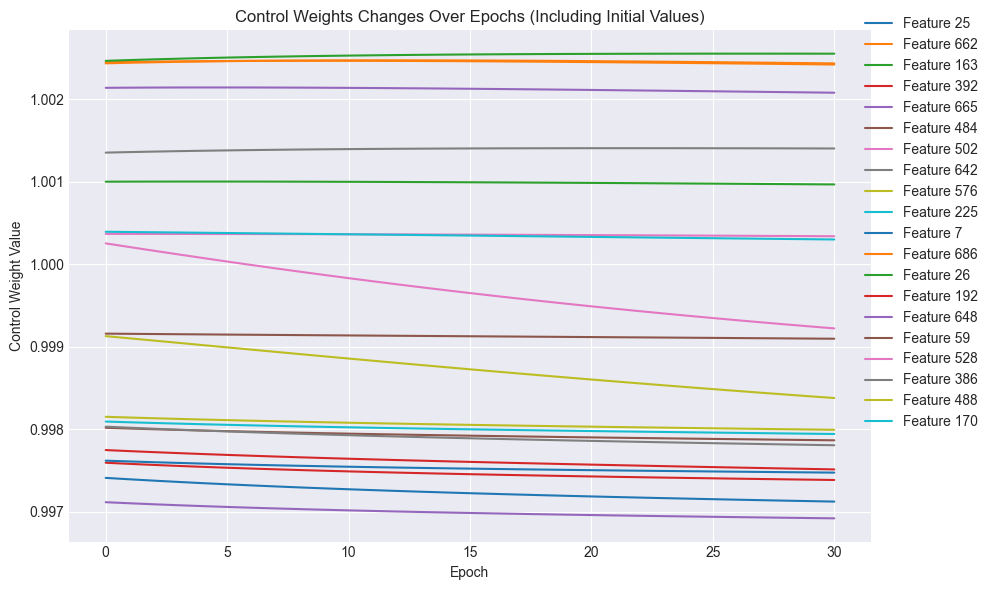

In [57]:
# 把控制权重的变化记录转换为 NumPy 数组，方便处理
control_weights_history = np.array(control_weights_history)

# 选择随机的 20 个特征用于可视化
num_features = control_weights_history.shape[1]
random_indices = np.random.choice(num_features, size=20, replace=False)

plt.figure(figsize=(10, 6))

# 画出每个特征的权重变化情况
for idx in random_indices:
    plt.plot(range(len(control_weights_history)), control_weights_history[:, idx], label=f'Feature {idx}')

plt.xlabel('Epoch')
plt.ylabel('Control Weight Value')
plt.title('Control Weights Changes Over Epochs (Including Initial Values)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))  # 把图例放到右侧，避免覆盖曲线
plt.tight_layout()
plt.show()

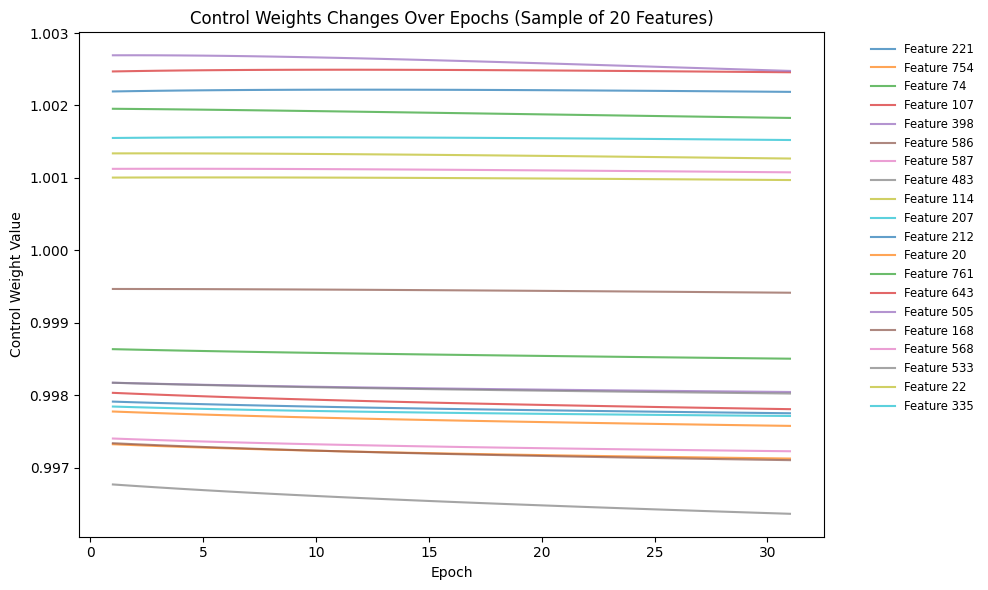

In [58]:
import random

# 绘制控制权重的变化曲线
def plot_control_weights(control_weights_history, num_features_to_plot=20):
    plt.style.use('default')
    plt.figure(figsize=(10, 6))
    num_epochs = len(control_weights_history)
    num_total_features = len(control_weights_history[0])

    # 随机选择 num_features_to_plot 个特征进行绘制
    sampled_features = random.sample(range(num_total_features), num_features_to_plot)

    # 绘制采样特征的控制权重变化
    for feature_idx in sampled_features:
        feature_weights = [epoch_weights[feature_idx] for epoch_weights in control_weights_history]
        plt.plot(range(1, num_epochs + 1), feature_weights, label=f'Feature {feature_idx + 1}', alpha=0.7)

    plt.xlabel('Epoch')
    plt.ylabel('Control Weight Value')
    plt.title(f'Control Weights Changes Over Epochs (Sample of {num_features_to_plot} Features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)
    plt.tight_layout()
    plt.show()

# 绘制控制权重变化 (采样 20 个特征)
plot_control_weights(control_weights_history, num_features_to_plot=20)


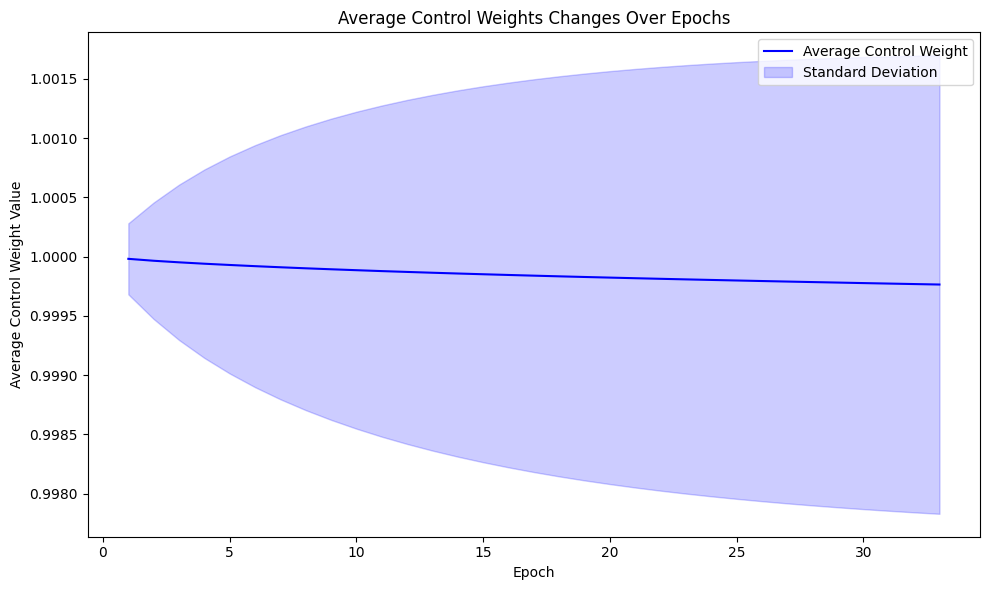

In [34]:
# 绘制控制权重的平均值变化
def plot_average_control_weight(control_weights_history):
    avg_weights = [np.mean(epoch_weights) for epoch_weights in control_weights_history]
    std_weights = [np.std(epoch_weights) for epoch_weights in control_weights_history]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(control_weights_history) + 1), avg_weights, label='Average Control Weight', color='blue')
    plt.fill_between(range(1, len(control_weights_history) + 1),
                     [avg - std for avg, std in zip(avg_weights, std_weights)],
                     [avg + std for avg, std in zip(avg_weights, std_weights)],
                     color='blue', alpha=0.2, label='Standard Deviation')

    plt.xlabel('Epoch')
    plt.ylabel('Average Control Weight Value')
    plt.title('Average Control Weights Changes Over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 绘制平均控制权重变化
plot_average_control_weight(control_weights_history)

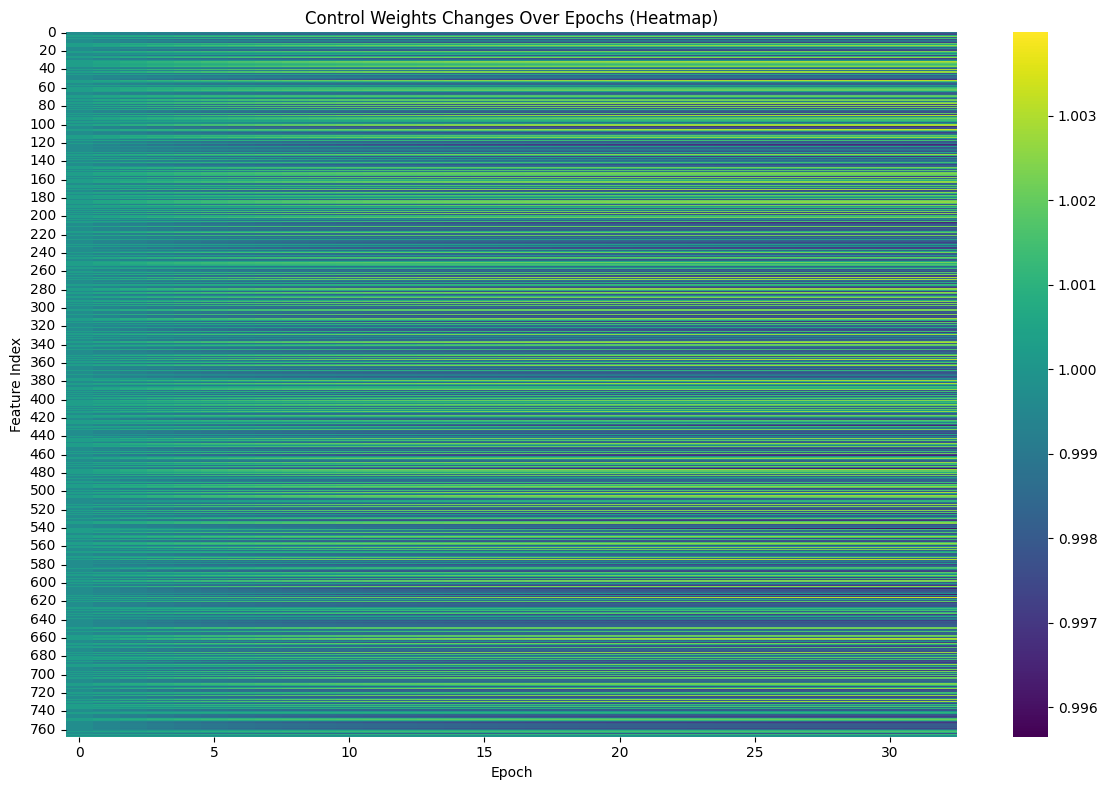

In [35]:
import seaborn as sns

# 绘制控制权重变化的热力图
def plot_control_weights_heatmap(control_weights_history):
    control_weights_array = np.array(control_weights_history)  # 转为 NumPy 数组
    plt.figure(figsize=(12, 8))
    sns.heatmap(control_weights_array.T, cmap='viridis', cbar=True, xticklabels=5, yticklabels=20)
    plt.xlabel('Epoch')
    plt.ylabel('Feature Index')
    plt.title('Control Weights Changes Over Epochs (Heatmap)')
    plt.tight_layout()
    plt.show()

# 绘制控制权重变化的热力图
plot_control_weights_heatmap(control_weights_history)


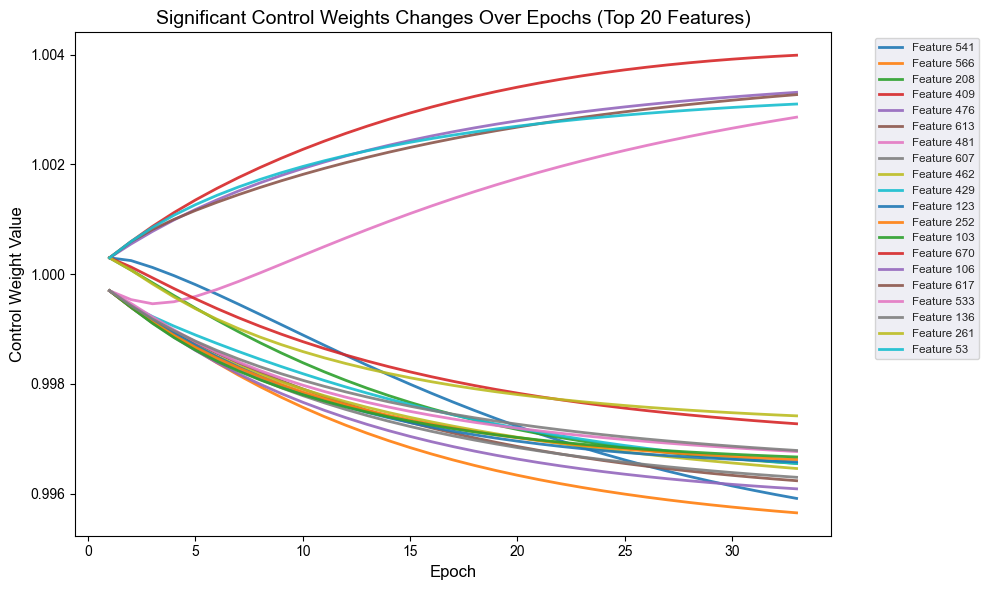

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 获取变化最显著的特征
def get_most_significant_features(control_weights_history, num_features_to_plot=20):
    control_weights_array = np.array(control_weights_history)
    feature_variations = np.ptp(control_weights_array, axis=0)  # 计算每个特征的变化范围 (最大值 - 最小值)
    significant_indices = np.argsort(-feature_variations)[:num_features_to_plot]  # 选取变化范围最大的特征索引
    return significant_indices

# 绘制有代表性的特征的控制权重变化
def plot_significant_control_weights(control_weights_history, num_features_to_plot=20):
    significant_indices = get_most_significant_features(control_weights_history, num_features_to_plot)
    control_weights_array = np.array(control_weights_history)

    plt.figure(figsize=(10, 6))
    for feature_idx in significant_indices:
        plt.plot(range(1, len(control_weights_history) + 1), control_weights_array[:, feature_idx],
                 label=f'Feature {feature_idx + 1}', linewidth=2, alpha=0.9)

    plt.style.use('seaborn-darkgrid')  # 使用 Seaborn 风格
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Control Weight Value', fontsize=12)
    plt.title(f'Significant Control Weights Changes Over Epochs (Top {num_features_to_plot} Features)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True)
    plt.tight_layout()
    plt.show()

# 绘制最有代表性的控制权重变化
plot_significant_control_weights(control_weights_history, num_features_to_plot=20)


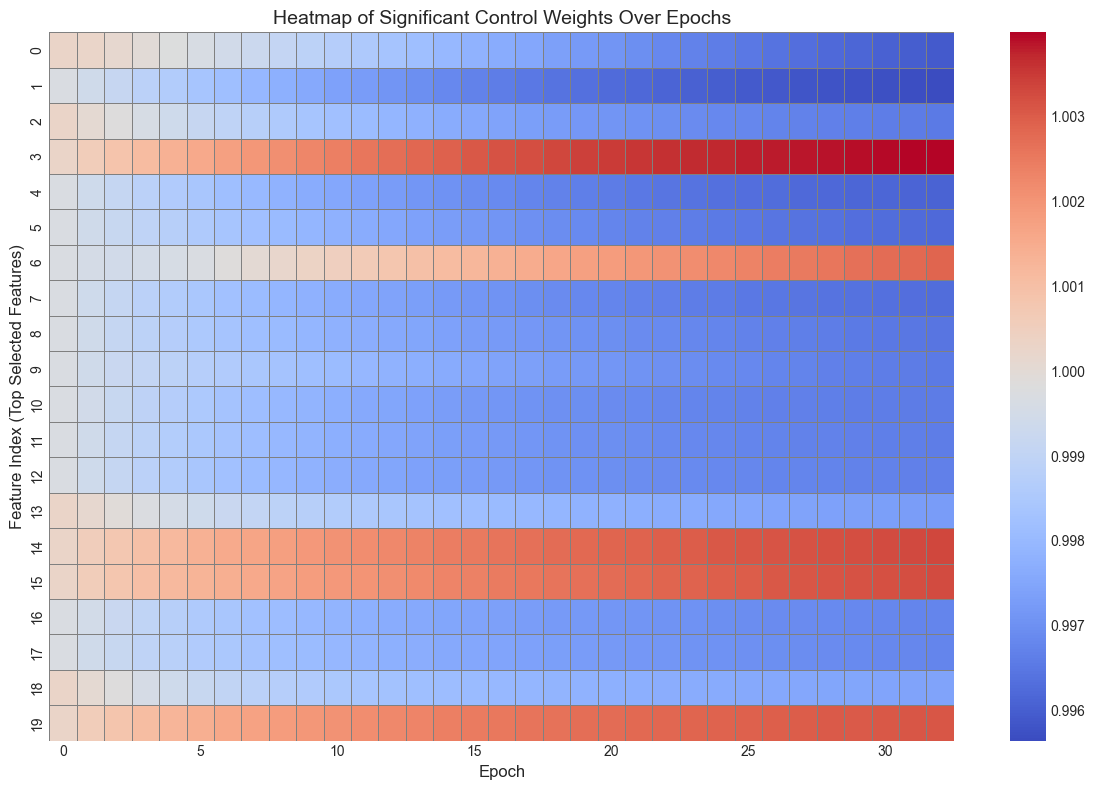

In [37]:
import seaborn as sns

# 绘制控制权重变化的热力图，显示最有代表性的特征
def plot_control_weights_heatmap(control_weights_history, num_features_to_plot=20):
    significant_indices = get_most_significant_features(control_weights_history, num_features_to_plot)
    control_weights_array = np.array(control_weights_history)
    significant_weights = control_weights_array[:, significant_indices]  # 只展示最显著特征的权重

    plt.figure(figsize=(12, 8))
    sns.heatmap(significant_weights.T, cmap='coolwarm', cbar=True, annot=False, xticklabels=5, yticklabels=1,
                linewidths=.5, linecolor='gray', fmt=".2f")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Feature Index (Top Selected Features)', fontsize=12)
    plt.title('Heatmap of Significant Control Weights Over Epochs', fontsize=14)
    plt.tight_layout()
    plt.show()

# 绘制控制权重变化的热力图
plot_control_weights_heatmap(control_weights_history, num_features_to_plot=20)


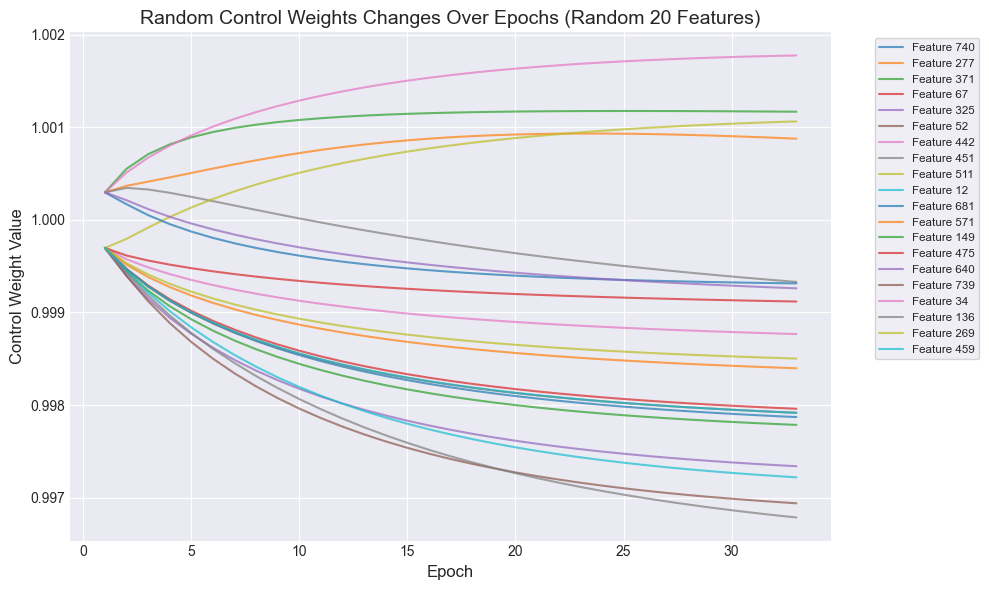

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 绘制随机选择的控制权重的变化曲线
def plot_random_control_weights(control_weights_history, num_features_to_plot=20):
    plt.figure(figsize=(10, 6))
    num_epochs = len(control_weights_history)
    num_total_features = len(control_weights_history[0])

    # 随机选择 num_features_to_plot 个特征进行绘制
    sampled_features = random.sample(range(num_total_features), num_features_to_plot)

    # 绘制采样特征的控制权重变化
    for feature_idx in sampled_features:
        feature_weights = [epoch_weights[feature_idx] for epoch_weights in control_weights_history]
        plt.plot(range(1, num_epochs + 1), feature_weights, label=f'Feature {feature_idx + 1}', linewidth=1.5, alpha=0.7)

    plt.style.use('seaborn-darkgrid')  # 使用 Seaborn 风格
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Control Weight Value', fontsize=12)
    plt.title(f'Random Control Weights Changes Over Epochs (Random {num_features_to_plot} Features)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True)
    plt.tight_layout()
    plt.show()

# 绘制随机选择的控制权重变化 (采样 20 个特征)
plot_random_control_weights(control_weights_history, num_features_to_plot=20)


In [23]:
# 其他分类器的对比实验
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Extra Tree': ExtraTreeClassifier(),
    'Gaussian NB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

In [24]:

def evaluate_classifiers(train_samples, val_samples, test_samples, classifiers, contrastive_model):
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    # 准备训练集数据
    for sample in train_samples:
        anchor = contrastive_model(sample['code_embedding'].view(-1).to(device)).cpu().detach().numpy().flatten()
        for pos in sample['positive_embeddings']:
            X_train.append(anchor + contrastive_model(pos.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_train.append(1)
        for neg in sample['negative_embeddings']:
            X_train.append(anchor + contrastive_model(neg.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_train.append(0)

    # 准备验证集数据
    for sample in val_samples:
        anchor = contrastive_model(sample['code_embedding'].view(-1).to(device)).cpu().detach().numpy().flatten()
        for pos in sample['positive_embeddings']:
            X_val.append(anchor + contrastive_model(pos.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_val.append(1)
        for neg in sample['negative_embeddings']:
            X_val.append(anchor + contrastive_model(neg.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_val.append(0)

    # 准备测试集数据
    for sample in test_samples:
        anchor = contrastive_model(sample['code_embedding'].view(-1).to(device)).cpu().detach().numpy().flatten()
        for pos in sample['positive_embeddings']:
            X_test.append(anchor + contrastive_model(pos.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_test.append(1)
        for neg in sample['negative_embeddings']:
            X_test.append(anchor + contrastive_model(neg.view(-1).to(device)).cpu().detach().numpy().flatten())
            y_test.append(0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    results = {}
    training_times = {}
    prediction_times = {}
    val_results = {}

    for name, clf in classifiers.items():
        start_time = time.time()  # 记录训练开始时间
        clf.fit(X_train, y_train)
        end_time = time.time()  # 记录训练结束时间
        training_time = end_time - start_time  # 计算训练时间
        training_times[name] = training_time

        # 验证集评估
        start_time = time.time()  # 记录预测开始时间
        y_val_pred = clf.predict(X_val)
        end_time = time.time()  # 记录预测结束时间
        val_prediction_time = end_time - start_time  # 计算预测时间

        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_results[name] = (val_acc, val_f1, val_recall, val_precision)

        # 测试集评估
        start_time = time.time()  # 记录预测开始时间
        y_pred = clf.predict(X_test)
        end_time = time.time()  # 记录预测结束时间
        prediction_time = end_time - start_time  # 计算预测时间
        prediction_times[name] = prediction_time

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        results[name] = (acc, f1, recall, precision)

    return results,  training_times, prediction_times

In [25]:
# 分类器对比结果
classifier_results, classifier_training_times, classifier_prediction_times = evaluate_classifiers(train_samples, val_samples,test_samples, classifiers, contrastive_model)

f:\Ana\11\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


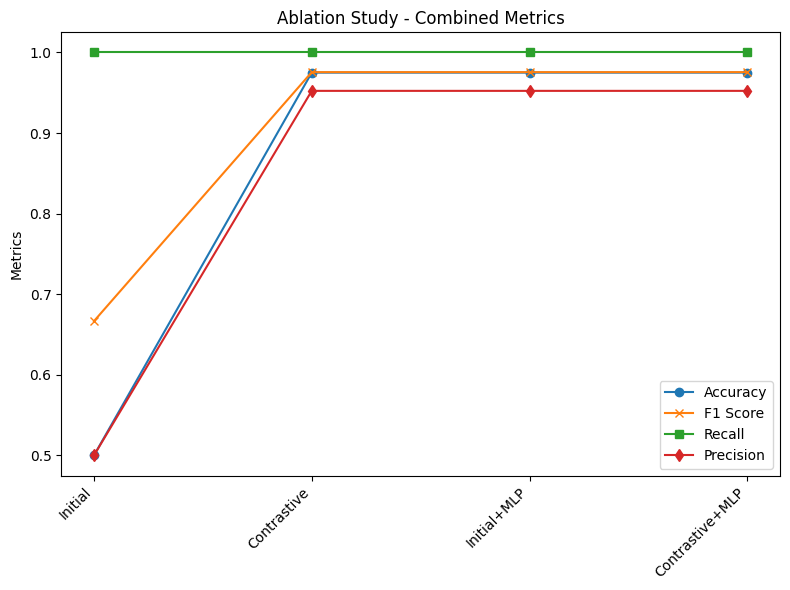

In [26]:
plt.style.use('default')
# 绘制消融实验结果
labels_ablation = ['Initial', 'Contrastive', 'Initial+MLP', 'Contrastive+MLP']
# acc
acc_values_ablation = [initial_acc, contrastive_acc, initial_mlp_acc, contrastive_mlp_acc]
#f1分数
f1_values_ablation = [initial_f1, contrastive_f1, initial_mlp_f1, contrastive_mlp_f1]
#召回率
recall_values_ablation = [initial_recall, contrastive_recall, initial_mlp_recall, contrastive_mlp_recall]
#准确率
precision_values_ablation=[initial_precision,contrastive_precision,initial_mlp_precision,contrastive_mlp_precision]
x_ablation = range(len(labels_ablation))

# 合并指标的消融实验图
plt.figure(figsize=(8, 6))
plt.plot(x_ablation, acc_values_ablation, label='Accuracy', marker='o')
plt.plot(x_ablation, f1_values_ablation, label='F1 Score', marker='x')
plt.plot(x_ablation, recall_values_ablation, label='Recall', marker='s')
plt.plot(x_ablation, precision_values_ablation, label='Precision', marker='d')
plt.xticks(x_ablation, labels_ablation, rotation=45, ha='right')
plt.ylabel('Metrics')
plt.title('Ablation Study - Combined Metrics')
plt.legend()
plt.tight_layout()
plt.savefig(time.time().__str__()+'Ablation Study - Combined Metrics'+".png")
plt.show()

In [27]:
# 绘制模型对比实验结果
labels_model_comparison = list(classifier_results.keys())
acc_values_model_comparison = [result[0] for result in classifier_results.values()]
f1_values_model_comparison = [result[1] for result in classifier_results.values()]
recall_values_model_comparison = [result[2] for result in classifier_results.values()]
precision_values_model_comparison = [result[3] for result in classifier_results.values()]


x_model_comparison = range(len(labels_model_comparison))



# # 合并指标的模型对比实验图
# plt.figure(figsize=(8, 6))
# plt.plot(x_model_comparison, acc_values_model_comparison, label='Accuracy', marker='o')
# plt.plot(x_model_comparison, f1_values_model_comparison, label='F1 Score', marker='x')
# plt.plot(x_model_comparison, recall_values_model_comparison, label='Recall', marker='s')
# plt.plot(x_model_comparison, precision_values_model_comparison, label='Precision', marker='d')
# plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
# plt.ylabel('Metrics')
# plt.title('Model Comparison - Combined Metrics')
# plt.legend()
# plt.tight_layout()
# plt.savefig(time.time().__str__()+'Model Comparison - Combined Metrics'+".png")
# plt.show()

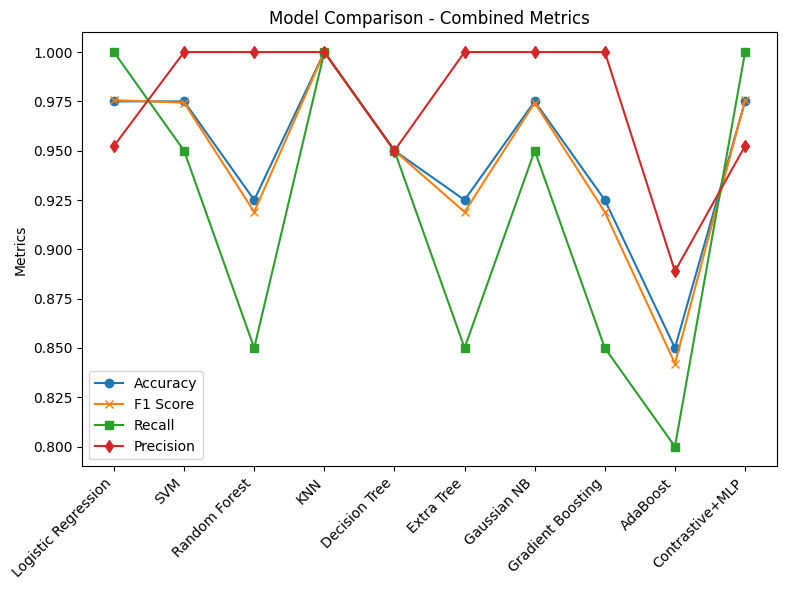

In [28]:
# 绘制综合模型对比实验结果
labels_model_comparison.append("Contrastive+MLP")
acc_values_model_comparison.append(contrastive_mlp_acc)
f1_values_model_comparison.append(contrastive_mlp_f1)
recall_values_model_comparison.append(contrastive_mlp_recall)
precision_values_model_comparison.append(contrastive_mlp_precision)

x_model_comparison = range(len(labels_model_comparison))

# 合并指标的模型对比实验图
plt.figure(figsize=(8, 6))
plt.plot(x_model_comparison, acc_values_model_comparison, label='Accuracy', marker='o')
plt.plot(x_model_comparison, f1_values_model_comparison, label='F1 Score', marker='x')
plt.plot(x_model_comparison, recall_values_model_comparison, label='Recall', marker='s')
plt.plot(x_model_comparison, precision_values_model_comparison, label='Precision', marker='d')
plt.xticks(x_model_comparison, labels_model_comparison, rotation=45, ha='right')
plt.ylabel('Metrics')
plt.title('Model Comparison - Combined Metrics')
plt.legend()
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Combined Metrics'+".png")
plt.show()

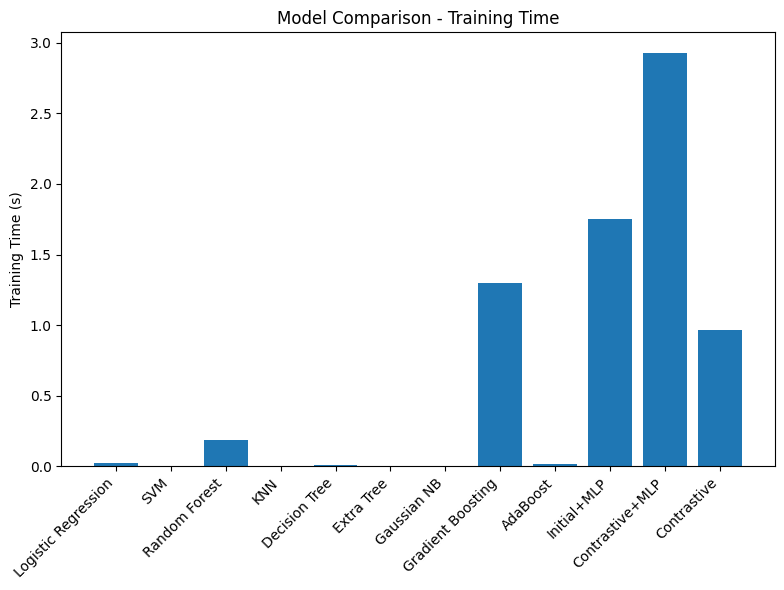

In [29]:
# 绘制训练时间对比图
training_times_model_comparison = list(classifier_training_times.values())
training_times_model_comparison.append(initial_mlp_training_time)
training_times_model_comparison.append(contrastive_mlp_training_time)
training_times_model_comparison.append(contrastive_training_time)

labels_training_time_comparison = list(classifier_training_times.keys())
labels_training_time_comparison.extend(['Initial+MLP', 'Contrastive+MLP', 'Contrastive'])

x_training_time_comparison = range(len(labels_training_time_comparison))

plt.figure(figsize=(8, 6))
plt.bar(x_training_time_comparison, training_times_model_comparison, tick_label=labels_training_time_comparison)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Training Time (s)')
plt.title('Model Comparison - Training Time')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Training Time'+".png")
plt.show()

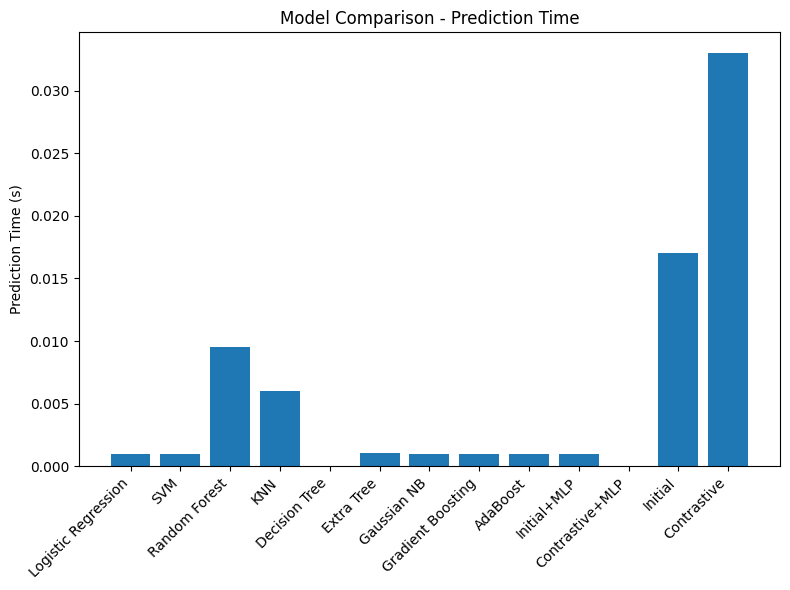

In [30]:
# 绘制预测时间对比图
prediction_times_model_comparison = list(classifier_prediction_times.values())
prediction_times_model_comparison.append(initial_mlp_prediction_time)
prediction_times_model_comparison.append(contrastive_mlp_prediction_time)
prediction_times_model_comparison.append(initial_prediction_time)
prediction_times_model_comparison.append(contrastive_prediction_time)

labels_prediction_time_comparison = list(classifier_prediction_times.keys())
labels_prediction_time_comparison.extend(['Initial+MLP', 'Contrastive+MLP', 'Initial', 'Contrastive'])

x_prediction_time_comparison = range(len(labels_prediction_time_comparison))

plt.figure(figsize=(8, 6))
plt.bar(x_prediction_time_comparison, prediction_times_model_comparison, tick_label=labels_prediction_time_comparison)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Prediction Time (s)')
plt.title('Model Comparison - Prediction Time')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Model Comparison - Prediction Time'+".png")
plt.show()

### 对比学习收敛图

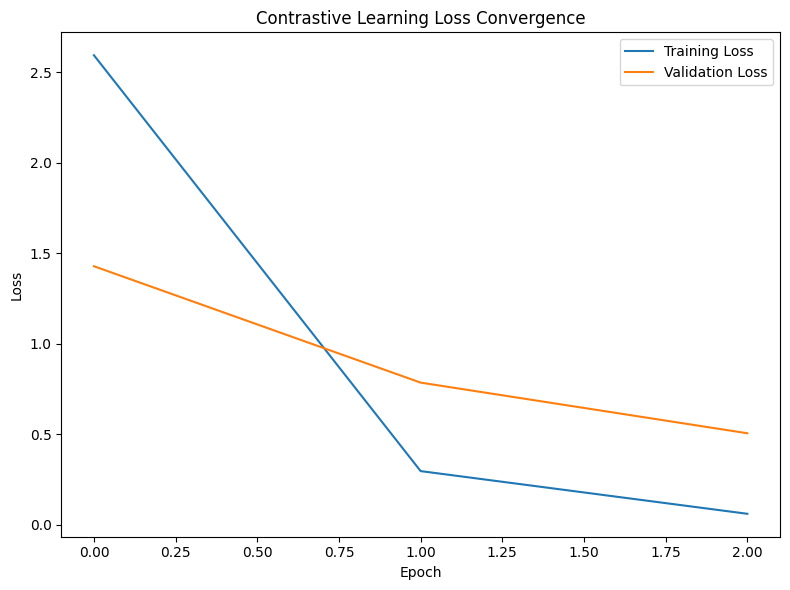

In [31]:
# 绘制对比学习的收敛图
plt.figure(figsize=(8, 6))
plt.plot(contrastive_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Loss Convergence')
plt.legend(loc='upper right')  # 将图例放在左上角
plt.tight_layout()
plt.savefig(time.time().__str__() + 'Contrastive Learning Loss Convergence' + ".png")
plt.show()

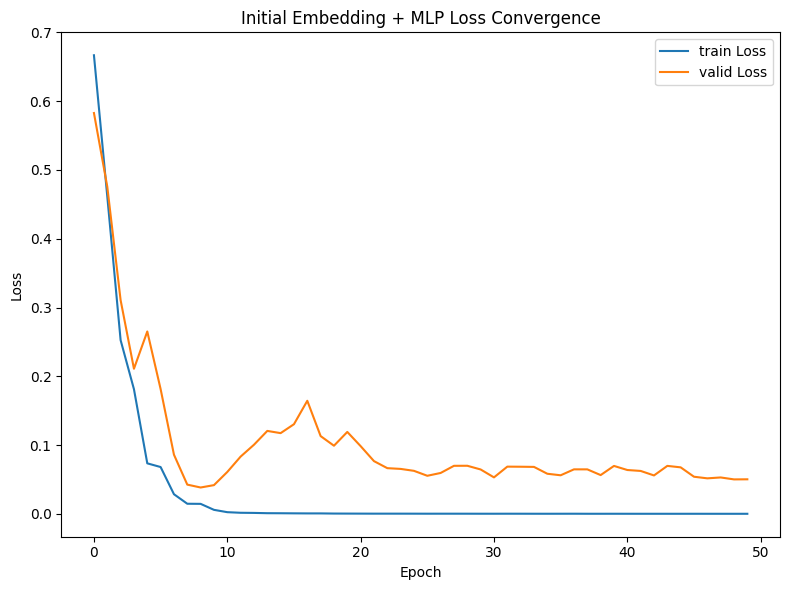

In [32]:
# 绘制在初始嵌入上MLP的收敛图
plt.figure(figsize=(8, 6))
plt.plot(initial_mlp_losses, label='train Loss')
plt.plot(initial_mlp_val_losses, label='valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')  # 将图例放在左上角
plt.title('Initial Embedding + MLP Loss Convergence')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Initial Embedding + MLP Loss Convergence'+".png")
plt.show()


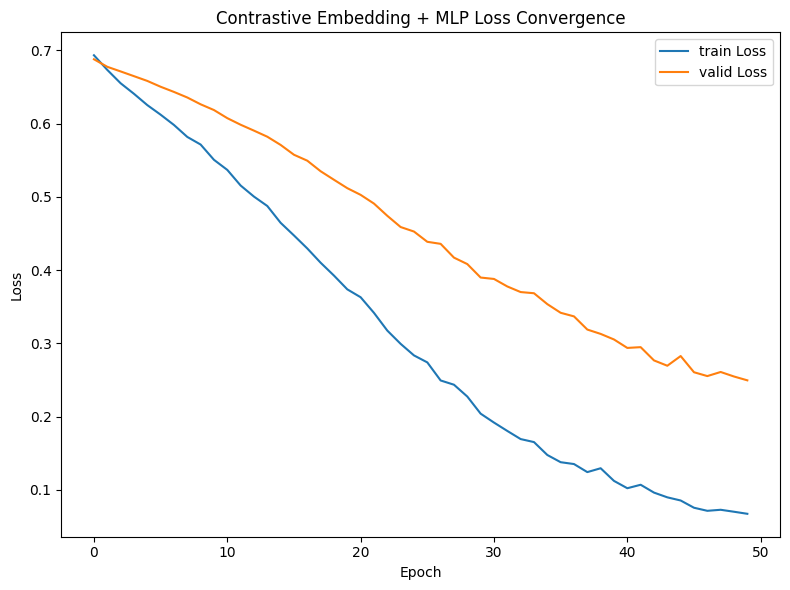

In [33]:
# 绘制在对比学习嵌入上MLP的收敛图
plt.figure(figsize=(8, 6))
plt.plot(contrastive_mlp_losses, label='train Loss')
plt.plot(contrastive_mlp_val_losses, label='valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')  # 将图例放在左上角
plt.title('Contrastive Embedding + MLP Loss Convergence')
plt.tight_layout()
plt.savefig(time.time().__str__()+'Contrastive Embedding + MLP Loss Convergence'+".png")
plt.show()

In [34]:
# 绘制T-SNE图
def plot_tsne(samples, contrastive_model=None, title=''):
    embeddings = []
    labels = []
    cnt=0
    for sample in samples:
        anchor = sample['code_embedding'].squeeze().numpy()
        embeddings.append(anchor)
        labels.append('anchor')
        for pos in sample['positive_embeddings']:
            embeddings.append(pos.squeeze().numpy())
            labels.append('positive')
        for neg in sample['negative_embeddings']:
            embeddings.append(neg.squeeze().numpy())
            labels.append('negative')
        cnt+=1
        if cnt==2:
            break
    if contrastive_model:
        contrastive_model.eval()
        embeddings = contrastive_model(torch.tensor(embeddings).to(device)).cpu().detach().numpy()

    embeddings = np.array(embeddings)  # 确保 embeddings 是 NumPy 数组

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for label in ['anchor', 'positive', 'negative']:
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.savefig(time.time().__str__()+title+".png")
    plt.show()

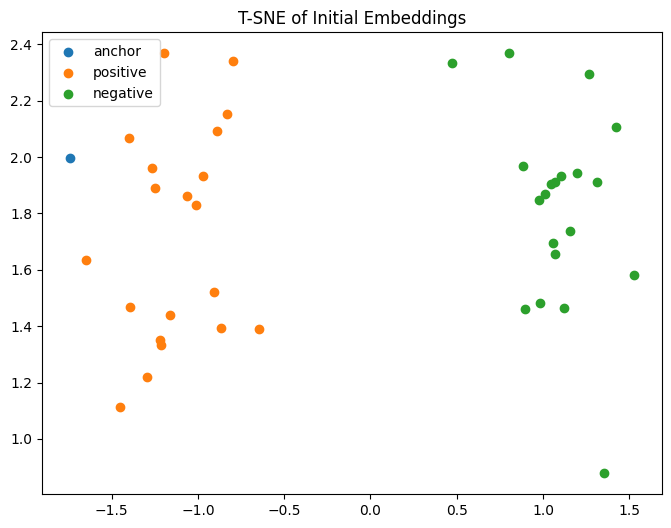

C:\Users\zengyou\AppData\Local\Temp\ipykernel_41000\332798698.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  embeddings = contrastive_model(torch.tensor(embeddings).to(device)).cpu().detach().numpy()


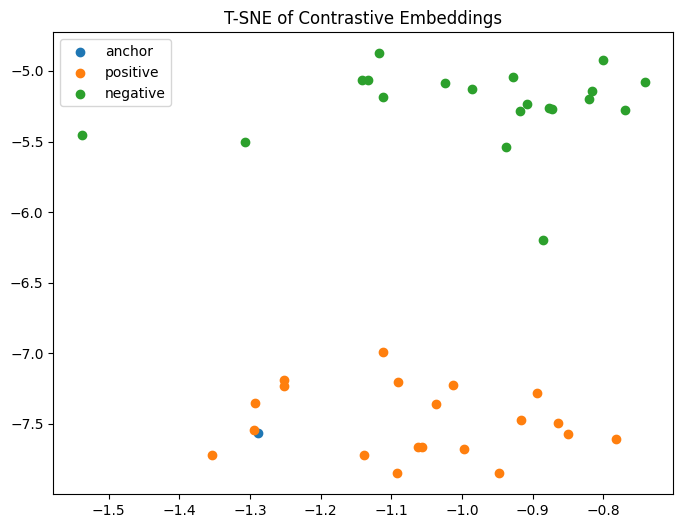

In [35]:
# 绘制T-SNE图：对比学习前后的嵌入分布
plot_tsne(test_samples, title='T-SNE of Initial Embeddings')
plot_tsne(test_samples, contrastive_model, title='T-SNE of Contrastive Embeddings')

In [36]:
# 打印所有实验结果
print("Ablation Study Results:")
print(f"Initial Embedding - ACC: {initial_acc}, F1: {initial_f1}, Recall: {initial_recall}, Precision: {initial_precision}, Prediction Time: {initial_prediction_time:.4f}s")
print(f"Contrastive Learning Embedding - ACC: {contrastive_acc}, F1: {contrastive_f1}, Recall: {contrastive_recall}, Precision: {contrastive_precision}, Training Time: {contrastive_training_time:.4f}s, Prediction Time: {contrastive_prediction_time:.4f}s")
print(f"Initial Embedding + MLP - ACC: {initial_mlp_acc}, F1: {initial_mlp_f1}, Recall: {initial_mlp_recall}, Precision: {initial_mlp_precision}, Training Time: {initial_mlp_training_time:.4f}s, Prediction Time: {initial_mlp_prediction_time:.4f}s")
print(f"Contrastive Learning Embedding + MLP - ACC: {contrastive_mlp_acc}, F1: {contrastive_mlp_f1}, Recall: {contrastive_mlp_recall}, Precision: {contrastive_mlp_precision}, Training Time: {contrastive_mlp_training_time:.4f}s, Prediction Time: {contrastive_mlp_prediction_time:.4f}s")

print("\nModel Comparison Results:")
for name, result in classifier_results.items():
    print(f"{name} - ACC: {result[0]}, F1: {result[1]}, Recall: {result[2]}, Precision: {result[3]}, Training Time: {classifier_training_times[name]:.4f}s, Prediction Time: {classifier_prediction_times[name]:.4f}s")

Ablation Study Results:
Initial Embedding - ACC: 0.5, F1: 0.6666666666666666, Recall: 1.0, Precision: 0.5, Prediction Time: 0.0170s
Contrastive Learning Embedding - ACC: 0.975, F1: 0.975609756097561, Recall: 1.0, Precision: 0.9523809523809523, Training Time: 0.9656s, Prediction Time: 0.0330s
Initial Embedding + MLP - ACC: 0.975, F1: 0.975609756097561, Recall: 1.0, Precision: 0.9523809523809523, Training Time: 1.7542s, Prediction Time: 0.0010s
Contrastive Learning Embedding + MLP - ACC: 0.975, F1: 0.975609756097561, Recall: 1.0, Precision: 0.9523809523809523, Training Time: 2.9276s, Prediction Time: 0.0000s

Model Comparison Results:
Logistic Regression - ACC: 0.975, F1: 0.975609756097561, Recall: 1.0, Precision: 0.9523809523809523, Training Time: 0.0240s, Prediction Time: 0.0010s
SVM - ACC: 0.975, F1: 0.9743589743589743, Recall: 0.95, Precision: 1.0, Training Time: 0.0030s, Prediction Time: 0.0010s
Random Forest - ACC: 0.925, F1: 0.9189189189189189, Recall: 0.85, Precision: 1.0, Traini